In [54]:
library(scPower)
library(reshape2)
library(ggplot2)
library(useful)
library(dplyr)
library(Seurat)
library(viridis)
library(data.table)
library(harmony)
library(stringr)
library(readr)
library(DESeq2)
library(tximportData)
library(tximport)
library(useful)



***scPower calculation Part 1 - expression power with reference scRNAseq dataset***



In [63]:
setwd("/home/jovyan/data/arthur_grant/lilian_data")
ST<-readRDS("prelim_ST_data.RDS")

In [64]:
###Subsample data
ST_100 = ST
ST_75 = subset(ST, cells = sample(Cells(ST), 2250))
ST_50 = subset(ST, cells = sample(Cells(ST), 1500))
ST_25 = subset(ST, cells = sample(Cells(ST), 750))

In [65]:
###Get raw data
data_100<-as.data.frame(as.matrix(GetAssayData(ST, slot = "counts")))
data_75<-as.data.frame(as.matrix(GetAssayData(ST_75, slot = "counts")))
data_50<-as.data.frame(as.matrix(GetAssayData(ST_50, slot = "counts")))
data_25<-as.data.frame(as.matrix(GetAssayData(ST_25, slot = "counts")))

In [66]:
###Build relevant metadata
meta_100<-dplyr::select(ST_100@meta.data, orig.ident, seurat_clusters)
colnames(meta_100)<-c("individual", "cell.type")
meta_100$individual<-as.character(meta_100$individual)
meta_100$cell.type<-as.character(meta_100$cell.type)

meta_75<-dplyr::select(ST_75@meta.data, orig.ident, seurat_clusters)
colnames(meta_75)<-c("individual", "cell.type")
meta_75$individual<-as.character(meta_75$individual)
meta_75$cell.type<-as.character(meta_75$cell.type)

meta_50<-dplyr::select(ST_50@meta.data, orig.ident, seurat_clusters)
colnames(meta_50)<-c("individual", "cell.type")
meta_50$individual<-as.character(meta_50$individual)
meta_50$cell.type<-as.character(meta_50$cell.type)

meta_25<-dplyr::select(ST_25@meta.data, orig.ident, seurat_clusters)
colnames(meta_25)<-c("individual", "cell.type")
meta_25$individual<-as.character(meta_25$individual)
meta_25$cell.type<-as.character(meta_25$cell.type)

In [67]:
meta_list<-list(ST_data_100 = meta_100, ST_data_75 = meta_75, ST_data_50 = meta_50, ST_data_25 = meta_25) 

In [68]:
total<-list(ST_data_100 = data_100, ST_data_75 = data_75, ST_data_50 = data_50, ST_data_25 = data_25)

In [69]:
###counting observed expressed genes for each 

expressed.genes.df<-NULL

for(name in names(total)){
    count.matrix<-total[[name]]
    annot.df<-data.frame(individual = meta_list[[name]]$individual, cell.type = meta_list[[name]]$cell.type)
    pseudo.bulk<-create.pseudobulk(count.matrix, annot.df)
    expressed.genes<-calculate.gene.counts(pseudo.bulk)
    num.expressed.genes<-nrow(expressed.genes)
    expressed.genes.df<-rbind(expressed.genes.df, data.frame(matrix=name,num.cells=ncol(count.matrix), expressed.genes=num.expressed.genes))
}

In [70]:
###Estimate negative binomial parameters for each gene

norm.mean.values<-NULL
disp.param<-NULL
for(name in names(total)){
    temp<-nbinom.estimation(total[[name]], sizeFactors="poscounts")
    norm.mean.values.temp<-temp[[1]] 
    norm.mean.values.temp$matrix<-name
    norm.mean.values<-rbind(norm.mean.values,norm.mean.values.temp)
    disp.param.temp<-temp[[3]] 
    disp.param.temp$matrix<-name 
    disp.param<-rbind(disp.param,disp.param.temp)
}

Loading required package: DESeq

Loading required package: locfit

locfit 1.5-9.4 	 2020-03-24


Attaching package: ‘locfit’


The following objects are masked from ‘package:useful’:

    left, right


Loading required package: lattice

    Welcome to 'DESeq'. For improved performance, usability and
    functionality, please consider migrating to 'DESeq2'.


Attaching package: ‘DESeq’


The following objects are masked from ‘package:DESeq2’:

    estimateSizeFactorsForMatrix, getVarianceStabilizedData,
    varianceStabilizingTransformation




In [71]:
print(disp.param)

            asymptDisp extraPois      matrix
asymptDisp   0.4891070 0.1335818 ST_data_100
asymptDisp1  0.5011244 0.1401110  ST_data_75
asymptDisp2  0.4826669 0.1559002  ST_data_50
asymptDisp3  0.5335945 0.1760486  ST_data_25


In [72]:
###Estimation of a gamma mixture distribution over all means

gamma.fits<-NULL
for(name in names(total)){
    censoredPoint<- 1 / ncol(total[[name]])
    norm.mean.values.temp<-norm.mean.values[norm.mean.values$matrix==name,] 
    gamma.fit.temp<-mixed.gamma.estimation(norm.mean.values.temp$mean, num.genes.kept = 21744, censoredPoint = censoredPoint)
    gamma.fit.temp$matrix<-name
    gamma.fits<-rbind(gamma.fits,gamma.fit.temp) 
}

Warning message in em(mean.vals, ncomp = 3, prop = c(zero.prop, 1 - (zero.prop + :
“Problem in the EM algorithm: likelihood is decreasing!”
Warning message in em(mean.vals, ncomp = 3, prop = c(zero.prop, 1 - (zero.prop + :
“Problem in the EM algorithm: likelihood is decreasing!”


In [79]:
print(gamma.fits)

               p1        p2        s1        s2       r1         r2      matrix
shape  0.01440194 0.9340559 0.2667786 0.2133076 4.914669 0.08341440 ST_data_100
shape1 0.02041075 0.9280153 0.2630057 0.2055471 4.781682 0.08053810  ST_data_75
shape2 0.02822128 0.9202059 0.2574745 0.1947074 4.542510 0.07636226  ST_data_50
shape3 0.04711828 0.9013174 0.2498386 0.1774275 4.227618 0.07056010  ST_data_25


In [110]:
g<-visualize.gamma.fits(norm.mean.values$mean[norm.mean.values$matrix=="ST_data_100"], gamma.fits[gamma.fits$matrix=="ST_data_100",],
nGenes=21000)

In [111]:
#Estimate the mean umi values per cell for each matrix
umi.values<-NULL
for(name in names(total)){
    mean.umi<-meanUMI.calculation(total[[name]])
    umi.values<-rbind(umi.values,data.frame(mean.umi,matrix=name)) 
}
print(umi.values)

  mean.umi      matrix
1 3975.615 ST_data_100
2 3981.438  ST_data_75
3 4003.189  ST_data_50
4 3986.845  ST_data_25


In [112]:
gamma.fits<-merge(gamma.fits,umi.values,by="matrix")
gamma.fits<-convert.gamma.parameters(gamma.fits)

In [ ]:
gamma.linear.fit.new<-umi.gamma.relation(gamma.fits, variable = "mean.umi")

In [ ]:
###compare estimated means with original means

g<-visualize.gamma.fits(norm.mean.values$mean[norm.mean.values$matrix=="GCA_data_75"], gamma.fits[gamma.fits$matrix=="GCA_data_75",], nGenes=21744)

In [92]:
mapped.reads<-data.frame(matrix=c("ST_data_100","ST_data_75","ST_data_50","ST_data_25"), transcriptome.mapped.reads=c(43524122,32395233,21365686,10981370))

In [93]:
sum(ST_100@meta.data$nCount_RNA)
sum(ST_75@meta.data$nCount_RNA)
sum(ST_50@meta.data$nCount_RNA)
sum(ST_25@meta.data$nCount_RNA)

[1] 12280675

[1] 8958235

[1] 6004784

[1] 2990134

       matrix mean.umi transcriptome.mapped.reads
1 ST_data_100 3975.615                   43524122
2  ST_data_25 3986.845                   10981370
3  ST_data_50 4003.189                   21365686
4  ST_data_75 3981.438                   32395233


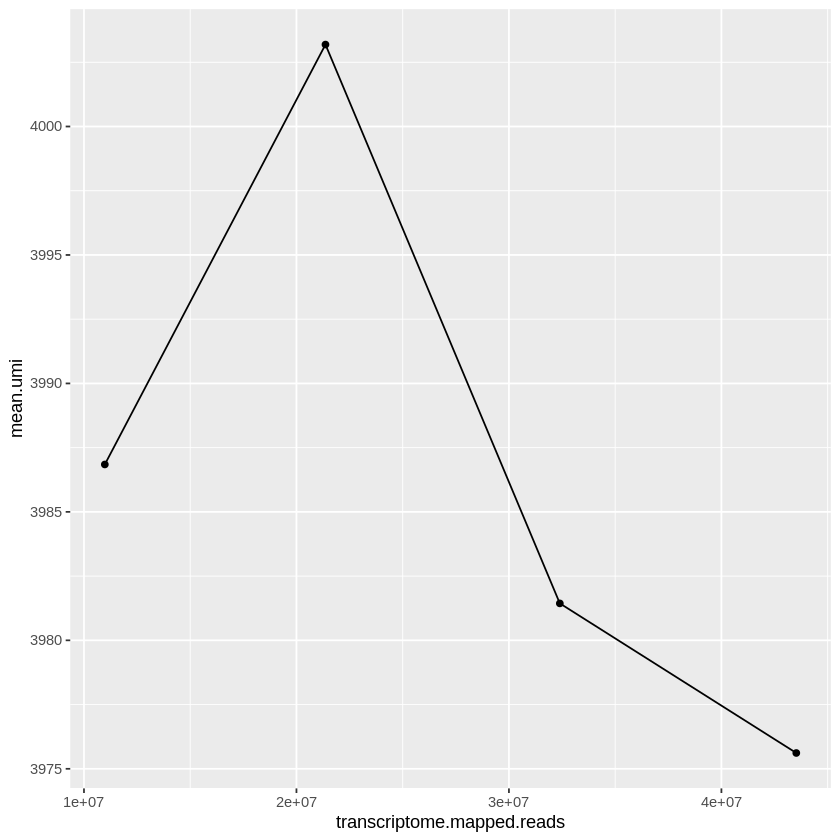

In [94]:
read.umis<-merge(umi.values,mapped.reads,by="matrix")
print(read.umis)
ggplot(read.umis,aes(x=transcriptome.mapped.reads,y=mean.umi))+
geom_point()+geom_line()

In [95]:
read.umi.fit.new<-umi.read.relation(read.umis)
print(read.umi.fit.new)

            intercept    reads
(Intercept)  4149.011 -9.54752


In [96]:
disp.fun.general.new<-dispersion.function.estimation(disp.param)
print(disp.fun.general.new)

  asymptDisp extraPois
1  0.4951157 0.1480056


In [ ]:


***Perform power calculation using this model data and AGP DEGs***




In [97]:
###Import DEGs from AGP paper CD4+ T cells

setwd("/home/jovyan/data/arthur_grant")
agp<-read.csv("AGP_data.csv")
agp<-dplyr::select(agp, name, Gene, FoldChange, p_value)

In [98]:
rank<-gene.rank.calculation(data_100, agp$Gene)

In [99]:
colnames(rank)<-c("Gene", "cumFraction", "rank")
agp_ref<-merge(agp, rank, by = "Gene")

In [101]:
dim(ST_100)
sum(ST_100@meta.data$nCount_RNA)

[1] 33538  3089

[1] 12280675

In [102]:
agp_ref<-agp_ref[agp_ref$FoldChange>1.2,]

In [103]:
transcriptome.mapped.reads<-14064027
nGenes<-22506
ct.freq<-0.4
ct<-"CD4_T"
cellsPerLane<-20000

cellsPerCelltype<-c(10000, 12500, 15000, 17500, 20000)
sampleSize<-c(4,6,8,10,12)
ref.study.name<-"agp"

In [ ]:
read.umi.fit.new$ct<-"CD4_T"
gamma.linear.fit.new$ct<-"CD4_T"
disp.fun.general.new$ct<-"CD4_T"

In [141]:
param.combis<-expand.grid(cellsPerCelltype,sampleSize, unique(agp_ref$name[agp_ref$name=="AGP"]))
colnames(param.combis)<-c("cellsPerCelltype","sampleSize","refStudyName")

In [142]:
res<-lapply(1:nrow(param.combis),function(i) 
    power.general.restrictedDoublets(param.combis$sampleSize[i],
                                     param.combis$cellsPerCelltype[i], 
                                     transcriptome.mapped.reads,
                                     ct.freq, 
                                     "de",
                                     ref.study=agp_ref,
                                     ref.study.name = "AGP", 
                                     cellsPerLane,
                                     read.umi.fit.new, 
                                     gamma.linear.fit.new,
                                     ct="New_ct",
                                     disp.fun.param=disp.fun.general.new, 
                                     mappingEfficiency = 1, 
                                     multipletRate=0,
                                     multipletFactor=1, 
                                     min.UMI.counts = 10,
                                     perc.indiv.expr = 0.5,
                                     nGenes=21000))
            
power.DE.study<-rbindlist(res)

In [143]:
power.DE.study<-reshape2::melt(power.DE.study, id.vars=c("name","sampleSize","totalCells",
                                         "usableCells","multipletFraction",
                                         "ctCells","readDepth",
                                         "readDepthSinglet","mappedReadDepth",
                                         "expressedGenes"))
power.DE.study$variable<-factor(power.DE.study$variable, levels=c("exp.probs","power","powerDetect"))
var.labs<-c("Expression probability", "DE power", "Detection power")
names(var.labs)<-c("exp.probs","power","powerDetect") 
power.DE.study$ctCells<-as.factor(power.DE.study$ctCells)

power.DE.study$sampleSize<-as.factor(power.DE.study$sampleSize) 



In [144]:
g.DE<-ggplot(power.DE.study,aes(x=ctCells,y=sampleSize,fill=value))+
geom_tile()+
geom_text(aes(label = round(value, 1)), size =5)+
facet_wrap(~variable,ncol=3,labeller = labeller(variable=var.labs))+ 
xlab("Number of measured cells per cell type and individual")+ 
ylab("Total sample size")+
scale_fill_viridis("Probability")+
theme_bw()+
theme(axis.title=element_text(size=10),
      axis.text=element_text(size=8), legend.title=element_text(size=8), legend.text=element_text(size=8))+coord_fixed()+
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

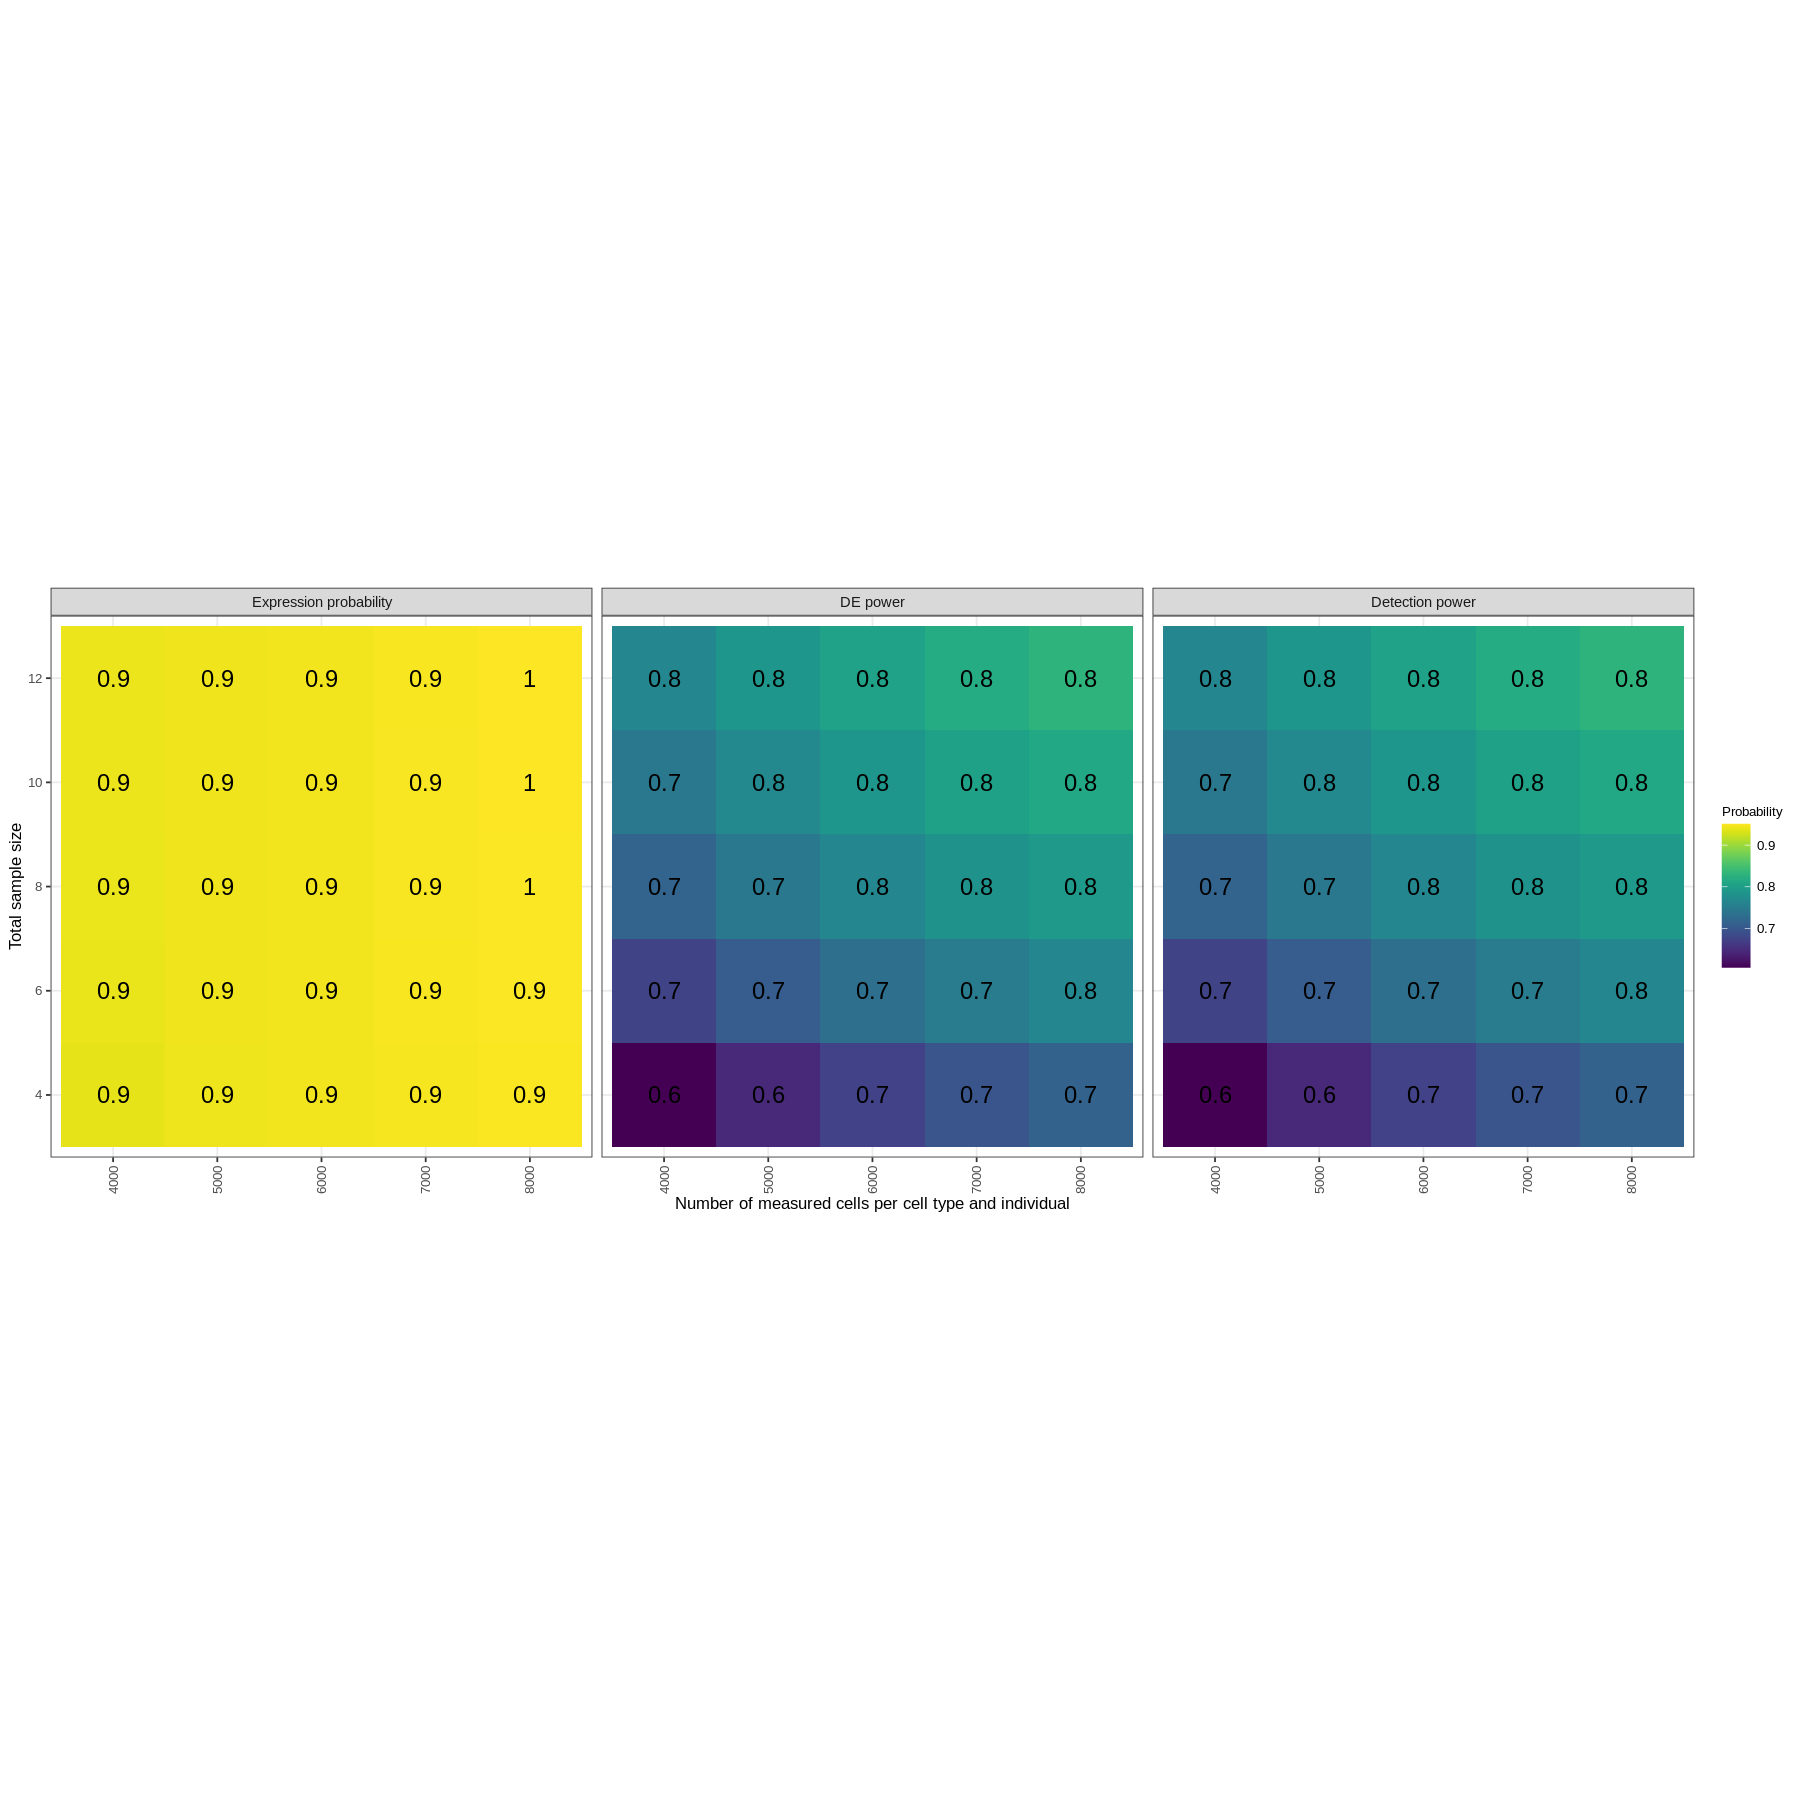

In [145]:
print(g.DE)